In [1]:
#!/home/kddmer/.pyenv/versions/env3/bin/python
# -*- coding: utf-8 -*-

import sys
import os
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
import cv2
sys.path.append("/home/kddmer/models/imgp/auto_wmr")
import estimate_watermark as ew
import preprocess as pp

# 预处理图像
# pp.preprocess('images/company_raw', 'images/company_proc')

In [2]:
# 识别水印位置
gx, gy, gxlist, gylist = ew.estimate_watermark('images/company_proc')
est = ew.poisson_reconstruct(gx, gy)
cropped_gx, cropped_gy = ew.crop_watermark(gx, gy)
W_m = ew.poisson_reconstruct(cropped_gx, cropped_gy)

    Computing gradients.
    Computing median gradients.


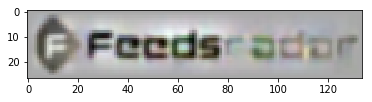

In [3]:
# est2 = ew.poisson_reconstruct2(gx, gy)
plt.imshow(ew.PlotImage(cropped_gy))
plt.show()
plt.imshow(ew.PlotImage(W_m))
plt.show()

In [4]:
W_mod = np.sqrt(np.square(gx) + np.square(gy))
W_mod = ew.PlotImage(W_mod)

In [5]:
# random photo
img = cv2.imread('images/company_proc/image17.jpg')
im, start, end = ew.watermark_detector(img, cropped_gx, cropped_gy)
print(start, end)
plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(im)
plt.show()

(147, 84) (29, 128)


In [6]:
import watermark_reconstruct as wr
proc_folder = '/home/kddmer/models/imgp/auto_wmr/images/company_proc'

num_images = len(gxlist)
Wm = W_m - W_m.min()
J, img_paths = wr.get_cropped_images(proc_folder, num_images, start, end, cropped_gx.shape)

ValueError: could not broadcast input array from shape (29,128,3) into shape (27,134,3)

In [7]:
print(cropped_gx.shape)

(19, 128, 3)


In [ ]:
import copy
alph_est = wr.estimate_normalized_alpha(J, Wm, num_images)
alph = np.stack([alph_est, alph_est, alph_est], axis=2)
C, est_Ik = wr.estimate_blend_factor(J, Wm, alph)

alpha = alph.copy()
for i in range(3):
	alpha[:,:,i] = C[i] * alpha[:, :, i]
Wm = Wm + alpha * est_Ik
W = copy.deepcopy(Wm)
for i in range(3): 
	W[:,:,i] /= C[i]
Jt = J
Wk, Ik, W, alpha1 = wr.solve_images(Jt, W_m, alpha, W)

    Estimating normalized alpha using 45 images.
     0.36065653204765724
     0.36039193655181395
     0.33884038299599856
    ------------------------------------
    Iteration: 0
    Step 1
        0
        1
        2
        3


In [9]:
k = 0
mg = 3 # 边缘经常有毛边，跳开这部分
for file in img_paths:
	img = cv2.imread(file)
	iw = 0
	for i in range(start[0]+mg, start[0]+end[0]-mg):	# start end形如: (229, 164) (39, 172)
		jw = 0
		for j in range(start[1]+mg, start[1]+end[1]-mg):
			img[i][j] = Ik[k][iw+mg][jw+mg]
			jw +=1
		iw +=1
	filewmr = file.split('.')[0] + '_wmr.' + file.split('.')[1]
	cv2.imwrite(filewmr, img)
	k +=1